## Aula 4 - Regressão linear múltipla

O modelo que fizemos acima considera uma única feature como preditora do preço da casa.

Mas temos outras 78 dessas features! Será que não há mais informação útil em todas essas outras variáveis?

Em geral, sim! É natural que esperemos que **mais variáveis** tragam **mais informações** ao modelo, e, portanto, o torne mais preciso! (embora, como veremos, não é verdade necessariamente que mais features nos deem um melhor modelo, em todos os casos).

Para incorporar estas outras variáveis ao modelo, é muito simples! 

Podemos passar a utilizar outros atributos (como o número de cômodos, qual é a renda média da vizinhança, etc.), e neste caso teremos uma **Regressão Linear Múltipla**, que é expressa pela seguinte função de hipótese:

$$ \hat{y} = f_{H, \vec{b}} = b_0 + b_1 X_1 + b_2 X_2 + \cdots + b_n X_n $$

Neste caso, além de $b_0$ e $b_1$, temos também outros coeficientes, um pra cada uma das $n$ features que escolhermos! Ou seja, o vetor de parâmetros tem $n+1$ dimensões:

$$\vec{b} = \begin{bmatrix}
b_0\\ 
b_1\\
\vdots\\
b_n
\end{bmatrix}$$

Modelos de regressão múltipla são potencialmente mais precisos, mas há também um lado ruim: nós perdemos a **possibilidade de visualização**. Agora, não temos mais uma reta, mas sim um **hiperplano** que relaciona todas as features com o target!

<img src="https://miro.medium.com/max/1120/0*rGSfRsMjiQeG5jof.png" width=500>

O OLS também é válido para a regressão linear múltipla, mas o fato de termos muitas variáveis faz com que os cálculos do problema de otimização sejam consideravelmente mais complicados.

Para facilitar este procedimento, é muito comum utilizarmos uma **notação matricial**, que facilita muitíssimo o cálculo do problema de otimização. Para os interessados, sugiro as referências, ou então [esta lecture](https://web.stanford.edu/~mrosenfe/soc_meth_proj3/matrix_OLS_NYU_notes.pdf).

Vamos construir esse modelo na prática com o sklearn!

Lembrando que podemos apenas passar pro sklearn **dados numéricos** e **preenchidos** (sem NaNs)!

Vamos ler os dados novamente, pra garantir

Em particular, NÃO estamos mais jogando fora aqueles dois outliers! Isso vai ser legal pra gente analisar sua influência no modelo final :)

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('dados_modelos/house_prices.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
X = df.drop(columns=['Id', 'SalePrice'])
y = df['SalePrice']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
X_train.select_dtypes(include=np.number).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1168 entries, 254 to 1126
Data columns (total 36 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1168 non-null   int64  
 1   LotFrontage    951 non-null    float64
 2   LotArea        1168 non-null   int64  
 3   OverallQual    1168 non-null   int64  
 4   OverallCond    1168 non-null   int64  
 5   YearBuilt      1168 non-null   int64  
 6   YearRemodAdd   1168 non-null   int64  
 7   MasVnrArea     1162 non-null   float64
 8   BsmtFinSF1     1168 non-null   int64  
 9   BsmtFinSF2     1168 non-null   int64  
 10  BsmtUnfSF      1168 non-null   int64  
 11  TotalBsmtSF    1168 non-null   int64  
 12  1stFlrSF       1168 non-null   int64  
 13  2ndFlrSF       1168 non-null   int64  
 14  LowQualFinSF   1168 non-null   int64  
 15  GrLivArea      1168 non-null   int64  
 16  BsmtFullBath   1168 non-null   int64  
 17  BsmtHalfBath   1168 non-null   int64  
 18  FullBa

In [6]:
nulos = X_train.select_dtypes(include=np.number).isnull().sum()
nulos[nulos > 0]

LotFrontage    217
MasVnrArea       6
GarageYrBlt     64
dtype: int64

In [7]:
X_train_model = X_train.select_dtypes(include=np.number).dropna(axis='columns')

X_test_model = X_test[X_train_model.columns]

In [8]:
assert(X_train_model.columns.tolist() == X_test_model.columns.tolist())
assert(X_test_model.isnull().sum().sum()== 0)

In [9]:
X_train_model.shape, X_test_model.shape

((1168, 33), (292, 33))

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import seaborn as sns

R2 0.82
MAE 22938.25
RMSE 37312.27
MAPE 13.45


<AxesSubplot: xlabel='SalePrice', ylabel='Count'>

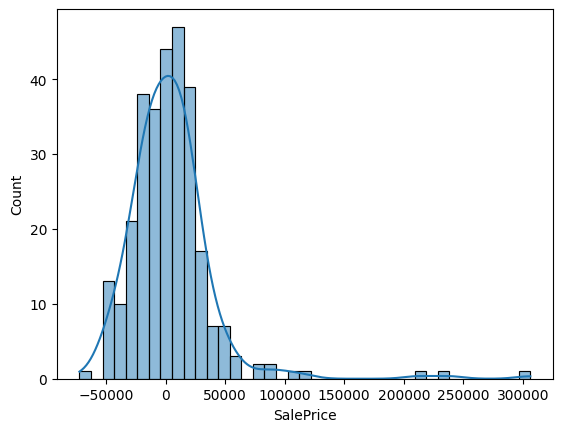

In [13]:
# Fit, construcao do modelo
estimador = LinearRegression()
estimador.fit(X_train_model, y_train)

# Avaliar o modelo
y_pred = estimador.predict(X_test_model)

r2 = r2_score(y_test, y_pred)

print(f'R2 {r2:.2f}')
print(f'MAE {mean_absolute_error(y_test, y_pred):.2f}')
print(f'RMSE {mean_squared_error(y_test, y_pred, squared=False):.2f}')
print(f'MAPE {mean_absolute_percentage_error(y_test, y_pred) * 100:.2f}')

residuos = y_test - y_pred
sns.histplot(residuos, kde=True)

In [14]:
estimador.intercept_

-48411.54387294524

In [20]:
estimador.coef_

array([-1.75548690e+02,  4.09174234e-01,  1.84955503e+04,  3.83573710e+03,
        3.37312908e+02,  1.80209917e+02,  1.00461555e+01, -4.61607099e+00,
        3.82786746e-01,  5.81287122e+00,  1.31240039e+01,  1.42134340e+01,
        4.50422890e+00,  3.18416668e+01,  1.10492803e+04, -3.26518493e+02,
        3.42606130e+03, -1.66531509e+03, -9.08810085e+03, -1.00971990e+04,
        5.10100134e+03,  4.37021557e+03,  1.16074917e+04,  5.58607730e-01,
        2.55639049e+01, -6.62562003e+00,  7.06908781e+00,  3.85262374e+01,
        6.55989735e+01, -3.73443286e+01, -7.15692563e-01, -2.09433750e+02,
       -5.14524004e+02])

In [21]:
X_test_model.columns

Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold'],
      dtype='object')

In [22]:
estimador.feature_names_in_

array(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'], dtype=object)

/tmp/ipykernel_78276/2125774392.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(X_train.corr())


<AxesSubplot: >

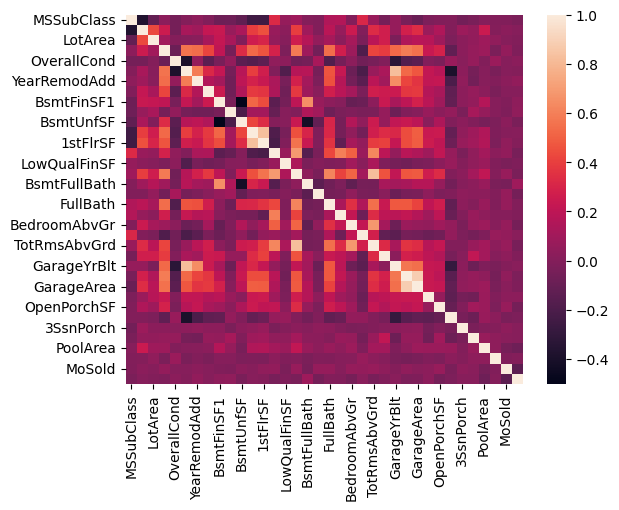

In [26]:
sns.heatmap(X_train.corr())

In [36]:
corr_feat_target = X_train_model.corr()['GarageArea']
corr_feat_target.sort_values()

OverallCond     -0.139431
EnclosedPorch   -0.124164
MSSubClass      -0.096140
KitchenAbvGr    -0.057930
BsmtHalfBath    -0.037577
LowQualFinSF    -0.033584
MiscVal         -0.032842
YrSold          -0.020336
BsmtFinSF2       0.003819
MoSold           0.017669
3SsnPorch        0.040029
ScreenPorch      0.059704
BedroomAbvGr     0.060613
PoolArea         0.079918
2ndFlrSF         0.143985
HalfBath         0.165690
BsmtFullBath     0.168789
LotArea          0.179124
BsmtUnfSF        0.194613
OpenPorchSF      0.224038
WoodDeckSF       0.231570
Fireplaces       0.256000
BsmtFinSF1       0.280523
TotRmsAbvGrd     0.335434
YearRemodAdd     0.364826
FullBath         0.410628
YearBuilt        0.466610
GrLivArea        0.478249
1stFlrSF         0.489108
TotalBsmtSF      0.490728
OverallQual      0.550476
GarageCars       0.882550
GarageArea       1.000000
Name: GarageArea, dtype: float64